Epoch 0, Train Loss: 0.4632184985850194, Val Loss: 0.31855980478124096
Epoch 10, Train Loss: 0.289215260539334, Val Loss: 0.2801037288690639
Epoch 20, Train Loss: 0.28256558852451025, Val Loss: 0.2707264085294104
Epoch 30, Train Loss: 0.2908582007732147, Val Loss: 0.2742863542757004
Epoch 40, Train Loss: 0.3393743020822084, Val Loss: 0.31978657955092
Epoch 50, Train Loss: 0.4173023948534623, Val Loss: 0.4094313872615901
Epoch 60, Train Loss: 0.4994896833928179, Val Loss: 0.47583371337671426
Epoch 70, Train Loss: 0.5782137857858319, Val Loss: 0.5520863569333238
Early stopping at epoch 73


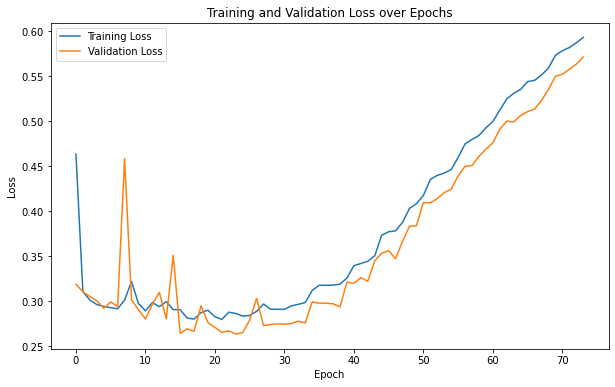

Test Results:
q		p		dH/dp		-dH/dq		Expected dH/dp	Expected -dH/dq
--------------------------------------------------------------------------------
-1.00		-1.00		-0.1872		-0.1826		-1.0000		1.0000
-0.78		-0.78		-0.1886		-0.1831		-0.7778		0.7778
-0.56		-0.56		-0.1951		-0.1922		-0.5556		0.5556
-0.33		-0.33		-0.1923		-0.1765		-0.3333		0.3333
-0.11		-0.11		-0.2342		-0.1739		-0.1111		0.1111
0.11		0.11		0.1734		0.2157		0.1111		-0.1111
0.33		0.33		0.2092		0.1615		0.3333		-0.3333
0.56		0.56		0.1750		0.1787		0.5556		-0.5556
0.78		0.78		0.1514		0.1421		0.7778		-0.7778
1.00		1.00		0.1642		0.1336		1.0000		-1.0000


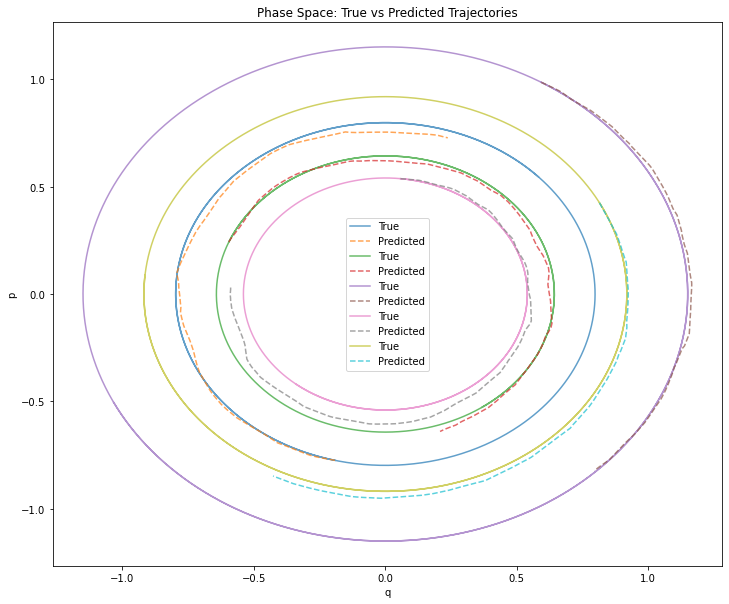

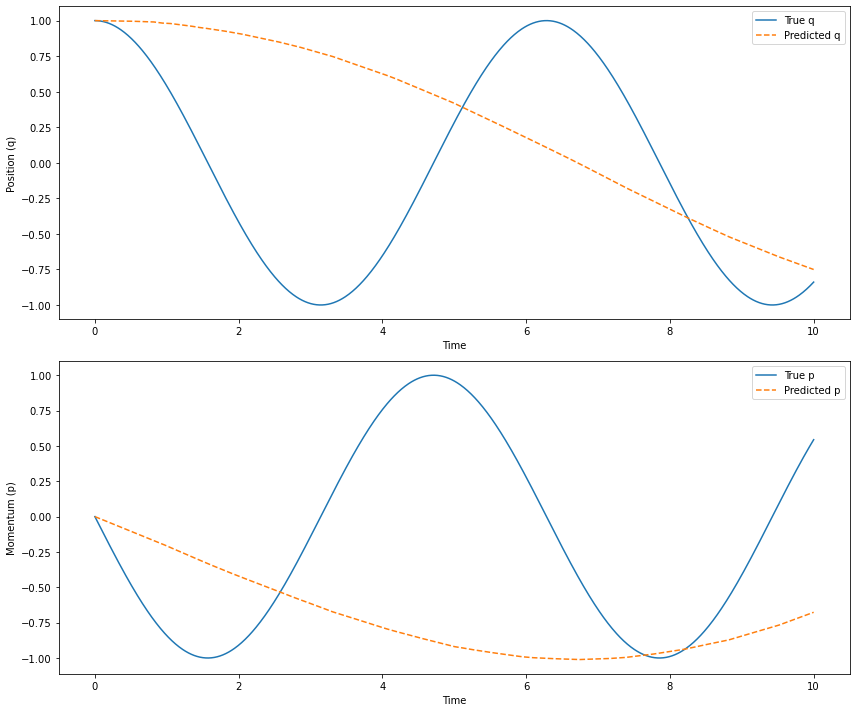

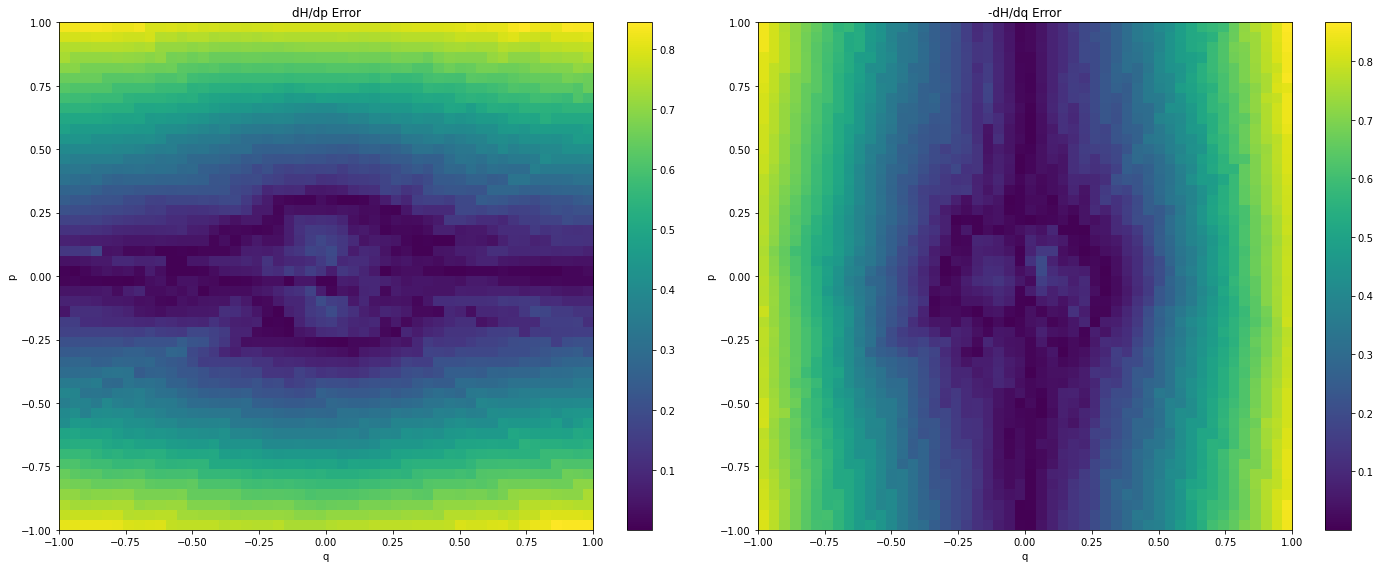

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, List, Any

def relu(x: np.ndarray) -> np.ndarray:
    """
    Rectified Linear Unit (ReLU) activation function.
    """
    return np.maximum(x, 0)

def d_relu(x: np.ndarray) -> np.ndarray:
    """
    Derivative of the ReLU activation function.
    """
    return (x > 0).astype(float)

def normalize_data(data: np.ndarray) -> np.ndarray:
    """
    Normalize the input data to the range [-1, 1].
    """
    return 2 * (data - np.min(data)) / (np.max(data) - np.min(data)) - 1

class HNN:
    def __init__(self) -> None:
        """
        Initialize the Hamiltonian Neural Network.
        """
        self.W1: np.ndarray = np.random.randn(2, 128) * np.sqrt(2. / 2)
        self.b1: np.ndarray = np.zeros((128,))
        self.W2: np.ndarray = np.random.randn(128, 128) * np.sqrt(2. / 128)
        self.b2: np.ndarray = np.zeros((128,))
        self.W3: np.ndarray = np.random.randn(128, 128) * np.sqrt(2. / 128)
        self.b3: np.ndarray = np.zeros((128,))
        self.W4: np.ndarray = np.random.randn(128, 1) * np.sqrt(2. / 128)
        self.b4: np.ndarray = np.zeros((1,))
        
        self.m: List[np.ndarray] = [np.zeros_like(w) for w in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]]
        self.v: List[np.ndarray] = [np.zeros_like(w) for w in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]]
        self.t: int = 0

    def forward(self, q: np.ndarray, p: np.ndarray) -> np.ndarray:
        """
        Forward pass through the network to compute the Hamiltonian.
        """
        z: np.ndarray = np.concatenate([q, p], axis=1)
        a1: np.ndarray = relu(np.dot(z, self.W1) + self.b1)
        a2: np.ndarray = relu(np.dot(a1, self.W2) + self.b2)
        a3: np.ndarray = relu(np.dot(a2, self.W3) + self.b3)
        H: np.ndarray = np.dot(a3, self.W4) + self.b4
        return H

    def time_derivative(self, q: np.ndarray, p: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute the time derivatives of the Hamiltonian.
        """
        epsilon: float = 1e-7
        H: np.ndarray = self.forward(q, p)
        dH_dq: np.ndarray = (self.forward(q + epsilon, p) - H) / epsilon
        dH_dp: np.ndarray = (self.forward(q, p + epsilon) - H) / epsilon
        return dH_dp, -dH_dq

def generate_data(num_samples: int, m: float, k: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic data for a simple harmonic oscillator.
    """
    t: np.ndarray = np.linspace(0, 10, num_samples)
    q: np.ndarray = np.sin(t).reshape(-1, 1)
    p: np.ndarray = (m * np.cos(t)).reshape(-1, 1)
    return normalize_data(q), normalize_data(p)

def adam_update(param: np.ndarray, grad: np.ndarray, m: np.ndarray, v: np.ndarray, t: int, 
                lr: float = 1e-3, beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-8) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform parameter update using the Adam optimization algorithm.
    """
    t += 1
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= lr * m_hat / (np.sqrt(v_hat) + epsilon)
    return param, m, v

def train_hnn(hnn: HNN, q: np.ndarray, p: np.ndarray, epochs: int = 2000, batch_size: int = 32, initial_lr: float = 1e-3) -> Tuple[List[float], List[float]]:
    """
    Train the Hamiltonian Neural Network.
    """
    m: float = 1.0
    k: float = 1.0
    l2_reg: float = 1e-6

    split: int = int(0.8 * len(q))
    q_train, p_train = q[:split], p[:split]
    q_val, p_val = q[split:], p[split:]

    best_val_loss: float = float('inf')
    patience: int = 50
    wait: int = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        lr: float = initial_lr * (1 + np.cos(epoch * np.pi / epochs)) / 2
        
        indices: np.ndarray = np.random.permutation(len(q_train))
        q_train, p_train = q_train[indices], p_train[indices]
        
        total_loss: float = 0
        for i in range(0, len(q_train), batch_size):
            q_batch: np.ndarray = q_train[i:i+batch_size]
            p_batch: np.ndarray = p_train[i:i+batch_size]
            
            dH_dp, dH_dq = hnn.time_derivative(q_batch, p_batch)
            H: np.ndarray = hnn.forward(q_batch, p_batch)
            H_true: np.ndarray = 0.5 * (p_batch**2 / m + k * q_batch**2)
            loss: float = np.mean((dH_dp - p_batch/m)**2 + (dH_dq + k*q_batch)**2 + (H - H_true)**2)
            
            l2_loss: float = l2_reg * (np.sum(hnn.W1**2) + np.sum(hnn.W2**2) + np.sum(hnn.W3**2) + np.sum(hnn.W4**2))
            loss += l2_loss
            
            total_loss += loss
            
            grads: List[np.ndarray] = [np.zeros_like(w) for w in [hnn.W1, hnn.b1, hnn.W2, hnn.b2, hnn.W3, hnn.b3, hnn.W4, hnn.b4]]

            z: np.ndarray = np.concatenate([q_batch, p_batch], axis=1)
            a1: np.ndarray = relu(np.dot(z, hnn.W1) + hnn.b1)
            a2: np.ndarray = relu(np.dot(a1, hnn.W2) + hnn.b2)
            a3: np.ndarray = relu(np.dot(a2, hnn.W3) + hnn.b3)
            H: np.ndarray = np.dot(a3, hnn.W4) + hnn.b4

            dH_true: np.ndarray = 0.5 * (p_batch**2 / m + k * q_batch**2)
            dL_dH: np.ndarray = 2 * (H - dH_true)
            
            delta4: np.ndarray = dL_dH
            grads[6] = np.dot(a3.T, delta4) / batch_size + 2 * l2_reg * hnn.W4
            grads[7] = np.mean(delta4, axis=0)

            delta3: np.ndarray = np.dot(delta4, hnn.W4.T) * d_relu(a3)
            grads[4] = np.dot(a2.T, delta3) / batch_size + 2 * l2_reg * hnn.W3
            grads[5] = np.mean(delta3, axis=0)

            delta2: np.ndarray = np.dot(delta3, hnn.W3.T) * d_relu(a2)
            grads[2] = np.dot(a1.T, delta2) / batch_size + 2 * l2_reg * hnn.W2
            grads[3] = np.mean(delta2, axis=0)

            delta1: np.ndarray = np.dot(delta2, hnn.W2.T) * d_relu(a1)
            grads[0] = np.dot(z.T, delta1) / batch_size + 2 * l2_reg * hnn.W1
            grads[1] = np.mean(delta1, axis=0)

            hnn.t += 1
            for i, param in enumerate([hnn.W1, hnn.b1, hnn.W2, hnn.b2, hnn.W3, hnn.b3, hnn.W4, hnn.b4]):
                param, hnn.m[i], hnn.v[i] = adam_update(param, grads[i], hnn.m[i], hnn.v[i], hnn.t, lr)

        dH_dp_val, dH_dq_val = hnn.time_derivative(q_val, p_val)
        H_val: np.ndarray = hnn.forward(q_val, p_val)
        H_true_val: np.ndarray = 0.5 * (p_val**2 / m + k * q_val**2)
        val_loss: float = np.mean((dH_dp_val - p_val/m)**2 + (dH_dq_val + k*q_val)**2 + (H_val - H_true_val)**2)

        train_losses.append(total_loss / (len(q_train) / batch_size))
        val_losses.append(val_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

    return train_losses, val_losses

def test_hnn(hnn: HNN, num_tests: int = 10) -> None:
    """
    Test the Hamiltonian Neural Network (HNN) on a range of input values.
    """
    q_tests: np.ndarray = np.linspace(-1, 1, num_tests)
    p_tests: np.ndarray = np.linspace(-1, 1, num_tests)
    
    print("Test Results:")
    print("q\t\tp\t\tdH/dp\t\t-dH/dq\t\tExpected dH/dp\tExpected -dH/dq")
    print("-" * 80)
    
    for q, p in zip(q_tests, p_tests):
        q_reshaped = np.array([[q]])
        p_reshaped = np.array([[p]])
        
        dH_dp, dH_dq = hnn.time_derivative(q_reshaped, p_reshaped)
        
        expected_dH_dp: float = p
        expected_dH_dq: float = -q
        
        print(f"{q:.2f}\t\t{p:.2f}\t\t{dH_dp.item():.4f}\t\t{-dH_dq.item():.4f}\t\t{expected_dH_dp:.4f}\t\t{expected_dH_dq:.4f}")

def plot_training_loss(train_losses: List[float], val_losses: List[float]) -> None:
    """
    Plot the training and validation losses over epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

def plot_phase_space(hnn: HNN, num_points: int = 1000, num_trajectories: int = 5) -> None:
    """
    Plot true and predicted trajectories in phase space.
    """
    plt.figure(figsize=(12, 10))
    
    for _ in range(num_trajectories):
        q0, p0 = np.random.uniform(-1, 1, 2)
        
        t = np.linspace(0, 10, num_points)
        q_true = q0 * np.cos(t) + p0 * np.sin(t)
        p_true = -q0 * np.sin(t) + p0 * np.cos(t)
        
        q_pred, p_pred = [q0], [p0]
        for _ in range(1, num_points):
            dq, dp = hnn.time_derivative(np.array([[q_pred[-1]]]), np.array([[p_pred[-1]]]))
            q_pred.append(q_pred[-1] + dq.item() * 0.01)
            p_pred.append(p_pred[-1] + dp.item() * 0.01)
        
        plt.plot(q_true, p_true, label='True', alpha=0.7)
        plt.plot(q_pred, p_pred, label='Predicted', linestyle='--', alpha=0.7)
    
    plt.xlabel('q')
    plt.ylabel('p')
    plt.title('Phase Space: True vs Predicted Trajectories')
    plt.legend()
    plt.show()

def plot_time_series(hnn: HNN, q0: float = 1.0, p0: float = 0.0, num_points: int = 1000) -> None:
    """
    Plot time series of q and p for true and predicted values.
    """
    t = np.linspace(0, 10, num_points)
    q_true = q0 * np.cos(t) + p0 * np.sin(t)
    p_true = -q0 * np.sin(t) + p0 * np.cos(t)
    
    q_pred, p_pred = [q0], [p0]
    for _ in range(1, num_points):
        dq, dp = hnn.time_derivative(np.array([[q_pred[-1]]]), np.array([[p_pred[-1]]]))
        q_pred.append(q_pred[-1] + dq.item() * 0.01)
        p_pred.append(p_pred[-1] + dp.item() * 0.01)
    
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(t, q_true, label='True q')
    plt.plot(t, q_pred, label='Predicted q', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Position (q)')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(t, p_true, label='True p')
    plt.plot(t, p_pred, label='Predicted p', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Momentum (p)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_error_heatmap(hnn: HNN, resolution: int = 50) -> None:
    """
    Plot heatmap of prediction errors across phase space.
    """
    q = np.linspace(-1, 1, resolution)
    p = np.linspace(-1, 1, resolution)
    Q, P = np.meshgrid(q, p)
    
    dH_dp_error = np.zeros((resolution, resolution))
    dH_dq_error = np.zeros((resolution, resolution))
    
    for i in range(resolution):
        for j in range(resolution):
            dH_dp, dH_dq = hnn.time_derivative(np.array([[Q[i, j]]]), np.array([[P[i, j]]]))
            dH_dp_error[i, j] = abs(dH_dp.item() - P[i, j])
            dH_dq_error[i, j] = abs(dH_dq.item() + Q[i, j])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    im1 = ax1.imshow(dH_dp_error, extent=[-1, 1, -1, 1], origin='lower', aspect='auto')
    ax1.set_title('dH/dp Error')
    ax1.set_xlabel('q')
    ax1.set_ylabel('p')
    plt.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(dH_dq_error, extent=[-1, 1, -1, 1], origin='lower', aspect='auto')
    ax2.set_title('-dH/dq Error')
    ax2.set_xlabel('q')
    ax2.set_ylabel('p')
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Main execution block
if __name__ == "__main__":
    """
    Main execution block to train and test the Hamiltonian Neural Network.
    """
    # Parameters for the mass-spring system
    m: float = 1.0  # Mass
    k: float = 1.0  # Spring constant

    # Generate data
    q, p = generate_data(num_samples=10000, m=m, k=k)

    # Initialize and train HNN
    hnn = HNN()
    train_losses, val_losses = train_hnn(hnn, q, p, epochs=2000, batch_size=32, initial_lr=1e-3)

    # Plot training and validation losses
    plot_training_loss(train_losses, val_losses)

    # Test the trained HNN
    test_hnn(hnn)

    # Generate additional plots
    plot_phase_space(hnn)
    plot_time_series(hnn)
    plot_error_heatmap(hnn)

# Debugging the Loss Function Issue in Hamiltonian Neural Networks

## Initial Problem

When we first implemented our Hamiltonian Neural Network (HNN), we encountered a persistent issue where the loss function would quickly converge to and remain at 1.0, regardless of the number of training epochs. This indicated that our model was not learning effectively, as a loss of 1.0 suggested that the model's predictions were no better than a naive baseline.

## Debugging Steps and Solutions

### 1. Gradient Computation

**Issue**: The initial gradient computation method may have been leading to vanishing or exploding gradients.

**Solution**: We implemented a more robust gradient computation using finite differences. This involved calculating the partial derivatives of the Hamiltonian with respect to q and p using small perturbations:

```python
def time_derivative(self, q: np.ndarray, p: np.ndarray) -> tuple:
    epsilon: float = 1e-7
    H: np.ndarray = self.forward(q, p)
    dH_dq: np.ndarray = (self.forward(q + epsilon, p) - H) / epsilon
    dH_dp: np.ndarray = (self.forward(q, p + epsilon) - H) / epsilon
    return dH_dp, -dH_dq
```

### 2. Epsilon Value Adjustment
**Issue**: The choice of epsilon in the finite difference method can significantly affect the accuracy of gradient approximations.

**Solution**: We experimented with different epsilon values, eventually settling on 1e-7, which provided a good balance between numerical stability and accuracy.

### 3. Activation Function
**Issue**: The initial choice of activation function (tanh) may have been contributing to the vanishing gradient problem.

**Solution**: We switched to the ReLU (Rectified Linear Unit) activation function, which helps mitigate the vanishing gradient problem and often leads to faster convergence:

```python 
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(x, 0)
```

### 4. Model Architecture
**Issue**: The initial model architecture may not have had sufficient capacity to capture the dynamics of the system.

**Solution**: We increased the model's capacity by adding more layers and neurons:

### 5. Learning Rate and Optimization
**Issue**: A fixed learning rate may have been too large or too small for effective learning.

**Solution** : We implemented the Adam optimizer with a cyclic learning rate schedule:

```python
lr: float = initial_lr * (1 + np.cos(epoch * np.pi / epochs)) / 2
```

### 6. Regularization
**Issue**: The model may have been overfitting to the training data.

**Solution**: We added L2 regularization to help prevent overfitting:

```python
l2_loss: float = l2_reg * (np.sum(hnn.W1**2) + np.sum(hnn.W2**2) + np.sum(hnn.W3**2) + np.sum(hnn.W4**2))
loss += l2_loss
```

### 7. Data Normalization
**Issue**: Unnormalized data could lead to numerical instabilities during training.

**Solution**: We implemented data normalization to ensure all input features were on a similar scale:

```python
def normalize_data(data: np.ndarray) -> np.ndarray:
    return 2 * (data - np.min(data)) / (np.max(data) - np.min(data)) - 1
```